<a href="https://colab.research.google.com/github/kropotin4/Notebooks/blob/master/NeuralNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Нейронная сеть

In [27]:
#@title
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import pickle
from numba import njit

%matplotlib inline

In [28]:
class FFSNNetwork():
 
    def init_WB(self):
        """ Random init Weight and Bias"""
        for i in range(self.nh + 1):
            self.W[i + 1] = np.random.randn(self.sizes[i], self.sizes[i + 1])\
                            * np.sqrt(2 / (self.sizes[i]))  # Correct for min NaN collapse
            self.B[i + 1] = np.zeros((1, self.sizes[i + 1]))
 
    def write_weight_bias(self, filepath):
        with open(filepath + 'FFSNN_weight.pcl', 'wb') as pfile:
            pickle.dump(self.W, pfile)
        with open(filepath + 'FFSNN_bias.pcl', 'wb') as pfile:
            pickle.dump(self.B, pfile)
 
    def read_weight_bias(self, filepath):
        with open(filepath + 'FFSNN_weight.pcl', 'rb') as pfile:
            self.W = pickle.load(pfile)
        with open(filepath + 'FFSNN_bias.pcl', 'rb') as pfile:
            self.B = pickle.load(pfile)
 
    def __init__(self, n_inputs, n_outputs, hidden_sizes=[2]):
        # Init function
        # n_inputs - Number of inputs going into the network.
        # n_outputs - Number of neurons in last layer: 1 - regression, else - classification
        # hidden_sizes - Expects a list of integers, represents the number of neurons present in the hidden layer.
 
        # intialize the inputs
        self.nx = n_inputs
        self.ny = n_outputs
        self.nh = len(hidden_sizes)
        self.sizes = [self.nx] + hidden_sizes + [self.ny]
 
        self.W = {}
        self.B = {}
        self.init_WB()
 
    @staticmethod
    @njit
    def h(x):
        """ Activation function """
        #return x / (1.0 + np.exp(-x)) # Swish
        return np.where(x > 0, x, 0.01 * x) # Lucky RuLU
        #return x * (x > 0) # RuLu
        #return 1.0 / (1.0 + np.exp(-x)) # sigmoid
 
    @staticmethod
    @njit
    def grad_h(x):
        """ Derivative activation function """
        #s = x / (1.0 + np.exp(-x))
        #return s + (1.0 / (1.0 + np.exp(-x))) * (1 - s)
        return np.where(x > 0, 1, 0.01) # Lucky RuLU (require A)
        #return 1. * (x > 0) # RuLu
        #return x * (1 - x) # sigmoid (require H)
 
    @staticmethod
    @njit
    def softmax(x):
        exps = np.exp(x)
        return exps / np.sum(exps)
 
 
    def forward_pass(self, x):
        self.A = {}
        self.H = {}
        self.A[0] = x.reshape(1, -1)
        self.H[0] = x.reshape(1, -1)
        for i in range(self.nh):
            self.A[i + 1] = np.matmul(self.H[i], self.W[i + 1]) + self.B[i + 1]
            self.H[i + 1] = self.h(self.A[i + 1])
 
        if self.ny == 1: # Regression
            self.A[self.nh + 1] = np.matmul(self.H[self.nh], self.W[self.nh + 1]) + self.B[self.nh + 1]
            self.H[self.nh + 1] = self.A[self.nh + 1] # self.h(self.A[self.nh + 1])
        else: # Classification
            self.A[self.nh + 1] = np.matmul(self.H[self.nh], self.W[self.nh + 1]) + self.B[self.nh + 1]
            self.H[self.nh + 1] = self.softmax(self.A[self.nh + 1])
 
        return self.H[self.nh + 1]
 
    def grad(self, x, y):
        self.forward_pass(x)
        self.dW = {}
        self.dB = {}
        self.dH = {}
        self.dA = {}
        L = self.nh + 1
        self.dA[L] = (self.H[L] - y)
        for k in range(L, 1, -1):
            self.dW[k] = np.matmul(self.H[k - 1].T, self.dA[k])
            self.dB[k] = self.dA[k]
            self.dH[k - 1] = np.matmul(self.dA[k], self.W[k].T)
            self.dA[k - 1] = np.multiply(self.dH[k - 1], self.grad_h(self.A[k - 1])) # H[k-1] to A[k-1]
        # First layer (dH[0] and dA[0] - useless)
        self.dW[1] = np.matmul(self.H[0].T, self.dA[1])
        self.dB[1] = self.dA[1]
 
    def fit(self, features, labels, epochs=1, learning_rate=1, initialise=True, display_loss=False,
            adv_train=False, adv_epochs=100, score='mse'):
 
        # initialise w, b
        if initialise:
            self.init_WB()
 
        if display_loss:
            X_test = features
            Y_test = labels
            loss = []
 
        shfk_cur = 1
        for e in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
            shfk_cur += 1
            if (adv_train and (shfk_cur == adv_epochs or e == 1)):
                shfk_cur = 1
                features_sh, labels_sh = shuffle(features, labels) # Shuffle data
                X, X_test, Y, Y_test = train_test_split(features_sh, labels_sh, test_size=0.1) # Split 90% data to train
            else:
                X = features
                Y = labels
 
            dW = {}
            dB = {}
            for i in range(self.nh + 1):
                dW[i + 1] = np.zeros((self.sizes[i], self.sizes[i + 1]))
                dB[i + 1] = np.zeros((1, self.sizes[i + 1]))
            for x, y in zip(X, Y):
                self.grad(x, y)
                for i in range(self.nh + 1):
                    dW[i + 1] += self.dW[i + 1]
                    dB[i + 1] += self.dB[i + 1]
 
            m = X.shape[1]
            for i in range(self.nh + 1):
                self.W[i + 1] -= learning_rate * dW[i + 1] / m
                self.B[i + 1] -= learning_rate * dB[i + 1] / m
 
            if display_loss:
                Y_pred = self.predict(X_test)
                if score == 'mse':
                    loss.append(mean_squared_error(Y_pred, Y_test))
                elif score == 'log':
                    loss.append(log_loss(Y_pred, Y_test))
                else:
                    raise Exception("Available score: 'mse' or 'log'")
 
        if display_loss:
            plt.plot(loss)
            plt.xlabel('Epochs')
            plt.ylabel('Mean Squared Error' if score == 'mse' else 'Cross Entropy Loss')
            plt.show()
 
    def predict(self, X):
        Y_pred = []
        for x in X:
            y_pred = self.forward_pass(x)
            Y_pred.append(y_pred)
        return np.array(Y_pred).squeeze()

# Star 1

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [30]:
#@title ## Параметры Star1 

DATA_PATH = "drive/MyDrive/Colab Notebooks/data/" #@param {type:"string"}
 
N_VAR = 6       #@param {type:"number"}
TRAIN_PR = 0.8  #@param {type:"slider", min:0, max:1, step:0.05}

In [31]:
path_end = str(N_VAR).zfill(4) + ".csv"
train_features = pd.read_csv(DATA_PATH + "lab1/train_features_" + path_end, header=None, squeeze=True)
train_labels   = pd.read_csv(DATA_PATH + "lab1/train_labels_"   + path_end, header=None, squeeze=True)
test_features  = pd.read_csv(DATA_PATH + "lab1/test_features_"  + path_end, header=None, squeeze=True)

test_labels    = pd.read_csv(DATA_PATH + "lab1.csv", header=None, squeeze=True)

hack_features = pd.read_csv(DATA_PATH + "hack_features.csv", header=None, squeeze=True)
hack_labels   = pd.read_csv(DATA_PATH + "hack_labels.csv", header=None, squeeze=True)

In [32]:
hack_features = pd.DataFrame({
    "x1": hack_features
})

train_features = pd.DataFrame({
    "x1": train_features
    })

In [33]:
# Split train_features/train_labels to 2 part (first - train, second - check)
train_features1, train_labels1, train_features2, train_labels2 \
    = train_test_split(train_features, train_labels, train_size=TRAIN_PR)
 
 
# Numpy
 
train_features_np = train_features.to_numpy()
train_features1_np = train_features1.to_numpy()
train_features2_np = train_features2.to_numpy()
 
train_labels_np = train_labels.to_numpy()
train_labels1_np = train_labels1.to_numpy()
train_labels2_np = train_labels2.to_numpy()
 
test_features_np = test_features.to_numpy()

In [34]:
#@title Тренировка сети: параметры

learning_rate = 0.00001 #@param {type:"number"}
epochs = 250            #@param {type:"integer"}
score = 'mse'           #@param ["mse", "log"]
#@markdown ---
display_loss=False      #@param {type:"boolean"}
initialise=False        #@param {type:"boolean"}
#@markdown ---
adv_train = False       #@param {type:"boolean"}
adv_epochs = 1000       #@param {type:"integer"}

## Тренировка сети

In [35]:
NNet = FFSNNetwork(1, 1, hidden_sizes=[8,8,8])
 
NNet.read_weight_bias(DATA_PATH)
NNet.fit(hack_features.to_numpy(), hack_labels.to_numpy(), learning_rate=learning_rate, epochs=epochs, display_loss=display_loss,
          adv_train=adv_train, adv_epochs=adv_epochs, score=score, initialise=initialise)
#NNet.write_weight_bias(DATA_PATH)
 
 
#save_result("lab1_star.csv", NNet2.predict(test_features_np))
 
NNet_pred = NNet.predict(train_features_np)
NNet_pred2 = NNet.predict(test_features_np)
print(r2_score(train_labels_np, NNet_pred))
print(r2_score(test_labels.to_numpy(), NNet_pred2))


0.9823623543926081
0.9714485034381792


## Графики

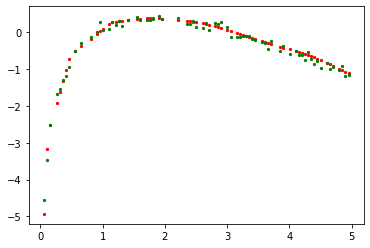

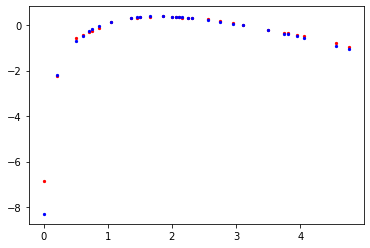

In [36]:
fig, ax = plt.subplots()
ax.scatter(train_features_np, NNet_pred, c='r', s=5)
ax.scatter(train_features_np, train_labels_np, c='g', s=5)
 
fig2, ax2 = plt.subplots()
ax2.scatter(test_features_np, NNet_pred2, c='r', s=5)
ax2.scatter(test_features_np, test_labels.to_numpy(), c='b', s=5)
 
plt.show()